# Deep Learning Project - Text Generation

by Youness Zaim & Matthieu Serres

In this file is presented the code that we used to create the application that generates a recipe from an ingredient.

The code is commented to be as clear as possible. \\
We also explain the issues we encountered during this project.

### 1. Importing the Libraries and Creating the Dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json
import zipfile


Then, we download the data.

We need a dataset with a title for each recipe, ingredients and their proportions as well as cooking instructions. \\
We use the 'Recipe-Box' data set which contains roughly 125k recipes.

We download this dataset using the following code:

In [2]:
# Create cache folder and Using get_file() it helps download the dataset files only once and execute faster.
dir = './tmp'
pathlib.Path(dir).mkdir(exist_ok=True)
# Download and unpack the dataset.
dataset_file_name = 'recipes_raw.zip'
dataset_file_origin = 'https://storage.googleapis.com/recipe-box/recipes_raw.zip'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=dir,
    extract=True,
    archive_format='zip'
)

print(dataset_file_path)

53362688/53355492 [==============================] - 1s 0us/step
./tmp/datasets/recipes_raw.zip


This dataset contains 3 files: recipes_raw_nosource_ar.json, recipes_raw_nosource_epi.json, recipes_raw_nosource_fn.json


In [3]:
!ls -la ./tmp/datasets/

total 251972
drwxr-xr-x 2 root root     4096 Jan  5 16:21 .
drwxr-xr-x 3 root root     4096 Jan  5 16:21 ..
-rw-r--r-- 1 root root    20437 Jan  5 16:21 LICENSE
-rw-r--r-- 1 root root 49784325 Jan  5 16:21 recipes_raw_nosource_ar.json
-rw-r--r-- 1 root root 61133971 Jan  5 16:21 recipes_raw_nosource_epi.json
-rw-r--r-- 1 root root 93702755 Jan  5 16:21 recipes_raw_nosource_fn.json
-rw-r--r-- 1 root root 53355492 Jan  5 16:21 recipes_raw.zip


We need to merge the information from these files in order to get: the title of the recipe, the ingredients with the quantities associated and the cooking instructions.

In [4]:
def load_dataset(silent=False):
    file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    for dataset_file_name in file_names:
        dataset_file_path = f'{dir}/datasets/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')

    return dataset  
dataset_raw = load_dataset() 
print('Total number of raw examples: ', len(dataset_raw))     

./tmp/datasets/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless, boneless chicke

We can see from these examples that we need to clean the data in order to be able to use it properly. \\
Indeed, in the example of the first file, the string 'ADVERTISEMENT' which appears after each ingredient must be eliminated for instance.

### 2. Cleaning and Preparing the Data

First, we need to deletes unpractical recipes: those without title, ingredients or instructions.

In [5]:
def validate_recipe(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

dataset_validated = [recipe for recipe in dataset_raw if validate_recipe(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalide recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 125164
Dataset size AFTER validation 122938
Number of invalide recipes 2226


We only lost 2226 recipes meaning that the data seems to be well constructed.

Then, we create a function that will convert the recipes to string which will make them easier to use as RNN input. \\
This function will also remove the noise string identified in the recipes of the first file.

In [6]:
# We need first to create stop words that will help the RNN to learn the structure of the recipes

STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'



def recipe_to_string(recipe):

    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

for recipe_index, recipe_string in enumerate(dataset_stringified[:10]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
---------
📗 Awesome Slow Cooker Pot Roast

🥕

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

📝

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Recipe 

We need to limit the number of characters in each recipe in order to speed up the training. \\
 We need to find a limit that will contain most of the recipes while keeping the training time quite low.

Note: We had huge issues with training time for this project. Whether it was a hardware limitation or a software limitation, we struggled to keep a reasonable training time. \\
We had to make concessions in order to limit our training time which lead to fairly bad results.

Therefore, given this issue, we had to limit the number of characters in ewch recipe at 100. This only gives 21 recipes which is way to low to construct a performant model but this was one of only ways to limit training time.

In normal conditions, we should set the limit around 2000 characters.

In [7]:
DEBUG = False
DEBUG_EXAMPLES = 10
MAX_RECIPE_LENGTH = 100
if DEBUG:
    MAX_RECIPE_LENGTH = 500

def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]
TOTAL_RECIPES_NUM = len(dataset_filtered)
print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', TOTAL_RECIPES_NUM)
print('Number of etiminated recipes: ', len(dataset_stringified) - TOTAL_RECIPES_NUM)

if DEBUG:
    dataset_filtered = dataset_filtered[:DEBUG_EXAMPLES]
    print('dataset_filtered.shape, ', len(dataset_filtered))
    

Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  21
Number of etiminated recipes:  122917


Then, we use tf.keras.preprocessing.text.Tokenizer to create a vocabulary from the recipes.

In [8]:
# Indicator of the end of the recipe.
STOP_SIGN = '␣'
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)
# Stop word is not a part of recipes, but tokenizer must know about it.
tokenizer.fit_on_texts([STOP_SIGN])
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1
tokenizer.fit_on_texts(dataset_filtered)
tokenizer.get_config()

#Adding +1 to take into account a special unassigned 0 index.
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

We create a function that vectorizes the dataset.

In [9]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)
recipe_sequence_to_string(dataset_vectorized[0])

📗 Title

🥕

• 1 cup rice
• 2 cup milk
• 3 cup wheat

📝

▪︎ ;



We add padding to sequences in order to have same length recipes for the training by using tf.keras.preprocessing.sequence.pad_sequences.


We use the stop sign '␣' that we add at the end of each recipe in order to make them all have the same length.

In [10]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure that all recipes will have at least 1 stop
    # sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
for recipe_index, recipe in enumerate(dataset_vectorized[:3]):
    print('Recipe #{} length before padding: {}'.format(recipe_index + 1, len(recipe)))
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:3]):
    print('Recipe #{} length after padding: {}'.format(recipe_index, len(recipe)))
recipe_sequence_to_string(dataset_vectorized_padded[0])

Recipe #1 length before padding: 61
Recipe #2 length before padding: 55
Recipe #3 length before padding: 37
Recipe #0 length after padding: 101
Recipe #1 length after padding: 101
Recipe #2 length after padding: 101
📗 Title

🥕

• 1 cup rice
• 2 cup milk
• 3 cup wheat

📝

▪︎ ;
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣


Because we set the maximum length of a recipe at 100 characters, the length after padding for all recipes will be 101 characters.

We create a TensorFlow dataset which will be easier to use for the training. \\
Here is an illustration of the tokenizer step. 

In [11]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

<TensorSliceDataset shapes: (101,), types: tf.int32>
Raw recipe:
 [18  2 33  9 10  5  3  1  1 19  1  1 12  2 23  2 13 14 11  2  7  9 13  3
  1 12  2 32  2 13 14 11  2 28  9  5 30  1 12  2 42  2 13 14 11  2 36 15
  3  8 10  1  1 20  1  1 16 17  2 31  1 52 52 52 52 52 52 52 52 52 52 52
 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52
 52 52 52 52 52] 



Stringified recipe:

📗 Title

🥕

• 1 cup rice
• 2 cup milk
• 3 cup wheat

📝

▪︎ ;
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣


We split the texts into input and target: \\
 \\
For each recipe, the input and target are 100 characters long. The input will have the 100 first characters (without the stop sign at the end) and the target will be the 100 last characters (without the first stop word:📗) of a recipe.

We have now 2 tuples for each recipe. As the indices are offset by 1 between input and target, this helps the model to predict characters in a recipe.

In [12]:
#we split the texts into input and target 
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text
dataset_targeted = dataset.map(split_input_target)
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))



Input sequence size: 100
Target sequence size: 100

Input:   '📗   T i t l e \n \n 🥕 \n \n •   1   c u p   r i c e \n •   2   c u p   m i l k \n •   3   c u p   w h e a'
Target:  '  T i t l e \n \n 🥕 \n \n •   1   c u p   r i c e \n •   2   c u p   m i l k \n •   3   c u p   w h e a t'
Step  1
  input: 18 ('📗')
  expected output: 2 (' ')
Step  2
  input: 2 (' ')
  expected output: 33 ('T')
Step  3
  input: 33 ('T')
  expected output: 9 ('i')
Step  4
  input: 9 ('i')
  expected output: 10 ('t')
Step  5
  input: 10 ('t')
  expected output: 5 ('l')
Step  6
  input: 5 ('l')
  expected output: 3 ('e')
Step  7
  input: 3 ('e')
  expected output: 1 ('\n')
Step  8
  input: 1 ('\n')
  expected output: 1 ('\n')
Step  9
  input: 1 ('\n')
  expected output: 19 ('🥕')
Step 10
  input: 19 ('🥕')
  expected output: 1 ('\n')


In order to minimize the training time and not use all the memory, we split the dataset into batches.

Given that we have only a small amount of recipes in our dataset and that we need to reduce the training time as much as possible, we chose a small batch size: 2.

In [13]:
BATCH_SIZE = 2
if DEBUG:
    BATCH_SIZE = DEBUG_EXAMPLES

SHUFFLE_BUFFER_SIZE = 1000
if DEBUG:
    SHUFFLE_BUFFER_SIZE = 1
    
if DEBUG:
    dataset_train = dataset_targeted \
        .repeat() \
        .batch(BATCH_SIZE, drop_remainder=True)
else:
    dataset_train = dataset_targeted \
      .shuffle(SHUFFLE_BUFFER_SIZE) \
      .batch(BATCH_SIZE, drop_remainder=True) \
      .repeat()
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[18  2 24  4  4  5  9  4  1  1 19  1  1 12  2 10  3  6 10  1 12  2 32  1
  12  2 42  1 12  2 43  1 12  2 48  1  1 20  1  1 16 17  2 23  1 16 17  2
   6 25 30 26 15  9  8  6 15 26 31 15 27 29 22 29 27 22 29 27 22 29 27 27
   1 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52
  52 52 52 52]
 [18  2 37  5  4  4 28  9 21 40  2 24  4  5  4  7  2 24  3 21 10  3  7 11
   9  3 13  3  1  1 19  1  1 12  2 37  5  4  4 28  9 21 40  2 24  4  5  4
   7  2 24  3 21 10  3  7 11  9  3 13  3  1  1 20  1  1 16 17  2 37  5  4
   4 28  9 21 40  2 24  4  5  4  7  2 24  3 21 10  3  7 11  9  3 13  3  1
  52 52 52 52]], shape=(2, 100), dtype=int32)
1st batch: target_text: tf.Tensor(
[[ 2 24  4  4  5  9  4  1  1 19  1  1 12  2 10  3  6 10  1 12  2 32  1 12
   2 42  1 12  2 43  1 12  2 48  1  1 20  1  1 16 17  2 23  1 16 17  2  6
  25 30 26 15  9  8  6 15 26 31 15 27 29 22 29 27 22 29 27 22 29 27 27  1
  52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 

### 3. Building the Model

Now that the data is cleaned and prepare, we can fit a model to it. \\
However, we need first to define and build the model that we will use.

In order to create our model, we used a RNN defined by tf.keras.Sequential. Our model works at the character level which means that given a character in the recipe, it will generate the next character.

We used 3 layers in this model:

*   Embedding layer as the input layer
*   LSTM layer which is performant for processing natural language
*   Dense layer as the output layer which generates logits predicting the log-likelihood of the next character.




We choose the LSTM layer because the recipes are written in natural language which well handled by LSTM.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (2, None, 256)            15104     
_________________________________________________________________
lstm (LSTM)                  (2, None, 1024)           5246976   
_________________________________________________________________
dense (Dense)                (2, None, 59)             60475     
Total params: 5,322,555
Trainable params: 5,322,555
Non-trainable params: 0
_________________________________________________________________


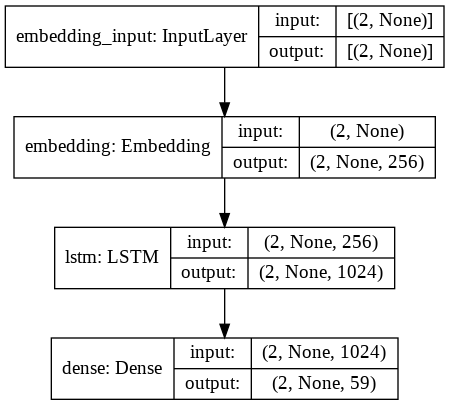

In [14]:
# Length of the vocabulary in characters.
vocab_size = VOCABULARY_SIZE
# Embedding dimension.
embedding_dim = 256
# Number of RNN units.
rnn_units = 1024

def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model
model = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
model.summary()
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_1.png'
)

Now that we have defined a model, we need an optimizer and a loss function.

We chose the ADAM optimizer and the sparse categorical cross entropy as a loss function

In [15]:
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### 4. Training

Our model is now ready and we need to train it on the data. In this case, we do not need a test set and the model will be trained on all the data.

As we encountered problems with training time, we chose a low number of epochs (50) and a low number of steps per epoch (only 20). This leads to bad results but is was necessary to have an acceptable training time.

In [17]:
EPOCHS=50
STEPS_PER_EPOCH = 20
print('EPOCHS:', EPOCHS)

EPOCHS: 50


We create a chekpoint to save the weights that we obtain after the training.

In [18]:
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

The following code is used to fit the model to the training set.

In [20]:
model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[
        checkpoint_callback,
    ]
)

model_name = 'recipe_generation_rnn_raw_'  + '.h5'
model.save(model_name, save_format='h5')

Epoch 1/50
20/20 [==============================] - 73s 4s/step - loss: 3.5012
Epoch 2/50
20/20 [==============================] - 71s 4s/step - loss: 2.4291
Epoch 3/50
20/20 [==============================] - 71s 4s/step - loss: 2.1028
Epoch 4/50
20/20 [==============================] - 71s 4s/step - loss: 1.9240
Epoch 5/50
20/20 [==============================] - 75s 4s/step - loss: 1.7533
Epoch 6/50
20/20 [==============================] - 70s 3s/step - loss: 1.5481
Epoch 7/50
20/20 [==============================] - 70s 4s/step - loss: 1.5205
Epoch 8/50
20/20 [==============================] - 71s 4s/step - loss: 1.2544
Epoch 9/50
20/20 [==============================] - 69s 3s/step - loss: 0.9289
Epoch 10/50
20/20 [==============================] - 71s 4s/step - loss: 0.9507
Epoch 11/50
20/20 [==============================] - 70s 3s/step - loss: 0.7586
Epoch 12/50
20/20 [==============================] - 71s 4s/step - loss: 0.6148
Epoch 13/50
20/20 [==============================

We can see that with all the concessions we have made, the training time is still around 1h. \\
With acceptable length limit for the recipes, bactch size, number of epoch and steps per epoch, the training time was more than 3 days.

### 5. Testing the Model

First, we rebuild the prediction model with a batch size of 1 in order to keep the prediction process simpler. \\
We load the wheights that we got after the training.

In [21]:
batch_size = 1
model_1_gen = build_model_1(vocab_size, embedding_dim, rnn_units, batch_size)
model_1_gen.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_1_gen.build(tf.TensorShape([batch_size, None]))

We can now build the function that we will use in order to call the model. \\
It will take as input the model, a key ingrient, a length for the output recipe and a temperature which represents how unexpected the final result will be: \\
 The lower the temperature, the more coherent, the result.

In [22]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))


Now, we use the model as intended by choosing an ingredient and a length for the receipe.

In [28]:
generate_text(
                model_1_gen,
                start_string='chicken',
                num_generate = 101,
                temperature=0.2)

'📗 chicken a rocks gariles\n\n📝\n\n▪︎ Mix 1 part soda to 1 part ale.\n␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣'

As we can see, the result is quite bad but it is mainly due to the fact that we only have 21 recipes left in our base. \\
Moreover, as the model processes character by character and not word by word, it is logical to have nonsense words such as 'gariles'.



Unfortunately, as the database is as poor as the one we could get (21 recipes only), we are unable to provide interesting stats about our model.

Finally, we save the model to make it easier to access it later.

In [ ]:
model_name = 'recipe_generation_rnn.h5'
model_1_gen.save(model_name, save_format='h5')

### 6. Creating the App

In order to make the model more user friendly, we created a simple app.

In [ ]:
import panel as pn
pn.extension() # loading panel's extension for jupyter compatibility 
text_input = pn.widgets.TextInput()

In [ ]:
generated_text = pn.pane.Markdown(object=text_input.value)

In [ ]:
text_input.link(generated_text, value='object')

Watcher(inst=TextInput(), cls=<class 'panel.widgets.input.TextInput'>, fn=<function Reactive.link.<locals>.link at 0x64d8d77a0>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False)

In [ ]:
text_input

TextInput()

In [ ]:
button = pn.widgets.Button(name="Generate Recipe",button_type="primary")

In [ ]:
slider = pn.widgets.FloatSlider(name='Choose your recipe length', width=200,start=0,end=1000)

In [ ]:
slider

FloatSlider(end=1000, name='Choose your r..., value_throttled=0, width=200)

In [ ]:
def click_cb(event):
    
    pred = generate_text(
                model_1_gen,
                start_string=generated_text.object,
                num_generate = int(slider.value),
                temperature=1)
    generated_text.object += pred

In [ ]:
button.on_click(click_cb)


In [ ]:
app = pn.Column(text_input, button, slider,generated_text); app


Column
    [0] TextInput()
    [1] Button(button_type='primary', name='Generate Recipe')
    [2] FloatSlider(end=1000, name='Choose your r..., value_throttled=0, width=200)
    [3] Markdown(str)

In [ ]:
app

Column
    [0] TextInput()
    [1] Button(button_type='primary', name='Generate Recipe')
    [2] FloatSlider(end=1000, name='Choose your r..., value_throttled=0, width=200)
    [3] Markdown(str)

In [ ]:
title = pn.pane.Markdown("# **Your Recipe Generator**")
desc = pn.pane.HTML("<marquee scrollamount='5'><b>Welcome to your recipe generator! In order to get started, please enter you favorite item for you meal of today. Bonne appetit!</b></marquee>")
final_app = pn.Column(title, desc ,app)

In [ ]:
final_app.show()

Launching server at http://localhost:56149
